## Normalizing Flows

Your task is to implement a version of Normalizing Flow for image generation. Our implementation will be based on RealNVP (https://arxiv.org/pdf/1605.08803.pdf) and we will be training on one class from MNIST. Your task is to read the paper in details and implement simple version of the algorithm from the paper:


1. Implement simple CouplingLayers (see RealNVP paper) with neural networks using a few fully connected layers with hidden activations of your choice. More on the CouplingLayers can be also found in https://arxiv.org/pdf/1410.8516.pdf. Remember to implement properly logarithm of a Jacobian determinant calculation. Implement only single scale architecture, ignore multiscale architecture with masked convolution and batch normalization. (2 points)
2. Implement RealNVP class combining many CouplingLayers with proper masking pattern (rememeber to alternate between unmodified pixels) with forward and inverse flows. (1 points)
3. Implement a loss function `nf_loss` (data log-likelihood) for the model. Hint: check `torch.distributions` (1 point)
4. Train your model to achieve good looking samples (similar to training set) and average per sample likelihood on training set lower than -1700. (2 points)
5. Sample from your model and pick 2 images (as visually different as possible) from your samples and plot 10 images that correspond to equally spaced linear interpolations in latent space between those images you picked. (1 point)
6. Use method from section 5.2 from https://arxiv.org/pdf/1410.8516.pdf with trained model and inpaint 5 sampled images with different random parts of your image occluded (50% of the image must be occluded). (2 point)
7. Write a report describing your solution, add loss plots and samples from the model. Write which hyperparameter sets worked for you and which did not. (1 point)

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

In [3]:
mask_layer0 = torch.tensor(range(28)) % 2 == 0
mask_layer1 = ~mask_layer0

mask_type0 = torch.stack([mask_layer0, mask_layer1] * 14, dim=0)
mask_type1 = torch.stack([mask_layer1] * 28, dim=0)
mask_type2 = mask_type1.T
mask_type3 = mask_type0[:14,:14].repeat_interleave(2, dim=0).repeat_interleave(2, dim=1)
mask_type4 = torch.randn(28,28) > 0

In [4]:
def plot(samples):
    length = len(samples)
    fig, ax = plt.subplots(1, length, figsize=(2*length, 2))
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    for j in range(length):
        ax[j].imshow(samples[j].cpu().numpy())
        ax[j].axis('off')
    plt.show()



class Coupling_layer(nn.Module):        
    def __init__(self, mask, hid_dim=128, *args, **kwargs):
        super(Coupling_layer, self).__init__()
        self.mask = mask
        self.d = mask.sum()
        self.D = len(mask)
        self.t_net = nn.Sequential(
            nn.Linear(self.d, hid_dim),
            nn.Sigmoid(),
            # nn.Linear(hid_dim, hid_dim),
            # nn.Sigmoid(),
            nn.Linear(hid_dim, self.D - self.d),
        )
        self.s_net = nn.Sequential(
            nn.Linear(self.d, hid_dim),
            nn.Sigmoid(),
            # nn.Linear(hid_dim, hid_dim),
            # nn.Sigmoid(),
            nn.Linear(hid_dim, self.D - self.d),
        )
    def split(self, x):
        bs = x.shape[0]
        xa = torch.masked_select(x, self.mask).reshape(bs, -1)
        xb = torch.masked_select(x, ~self.mask).reshape(bs, -1)
        return xa, xb
    def merge(self, xa, xb):
        bs = xa.shape[0]
        x = torch.zeros((bs, self.D))
        x[:, self.mask] = xa
        x[:, ~self.mask] = xb
        return x

    def forward_flow(self, x):
        xd, xr = self.split(x)

        s = self.s_net(xd)
        t = self.t_net(xd)

        z = self.merge(xd, xr * torch.exp(s) + t)
        logdetJ = s.sum(dim=1)

        return z, logdetJ
          
    def inverse_flow(self, z):
        zd, zr = self.split(z)

        s = self.s_net(zd)
        t = self.t_net(zd)
       
        x = self.merge(zd, (zr - t) * torch.exp(-s))
        return x
    
class RealNVP(nn.Module):
    def __init__(self, masks, layers_num=10, hid_dim=128, *args, **kwargs):
        super(RealNVP, self).__init__()
        self.coupling_layers = nn.ModuleList([
              Coupling_layer(masks[i].reshape(-1), hid_dim=hid_dim) for i in range(layers_num)
        ])
    
    def forward_flow(self, x):
        org_shape = x.shape
        logdetJ = 0
        z = x.reshape(org_shape[0], -1)
        for cl in self.coupling_layers:
            z, logdetJ_ = cl.forward_flow(z)
            logdetJ += logdetJ_
        return z.reshape(org_shape), logdetJ
    
    def inverse_flow(self, z):
        org_shape = z.shape
        x = z.reshape(org_shape[0], -1)
        for cl in reversed(self.coupling_layers):
            x = cl.inverse_flow(x)
        return x.reshape(org_shape)

normal = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
def nf_loss(z, logdetJ):
    logdetJ = logdetJ.reshape(-1, 1, 1)
    return -(normal.log_prob(z) + logdetJ).mean()


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(root=r'./mnist/', 
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = DataLoader(x, batch_size=128, shuffle=True)

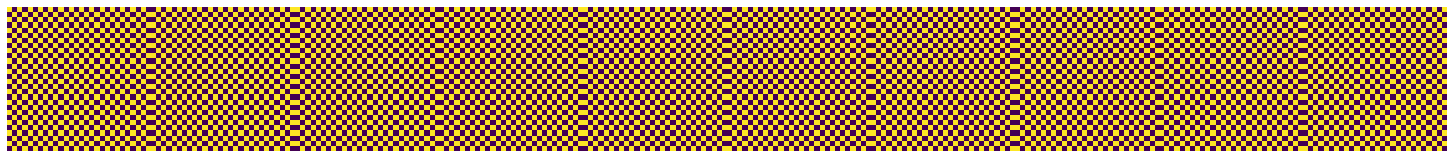

In [6]:
# masks = [mask_type0, ~mask_type0, mask_type1, ~mask_type1, mask_type2, ~mask_type2, mask_type3, ~mask_type3, mask_type4, ~mask_type4]
# masks = [mask_type0, ~mask_type0, mask_type1, ~mask_type1, mask_type3, ~mask_type3, mask_type2, ~mask_type2, mask_type0, ~mask_type0]
masks = [mask_type0, ~mask_type0] * 5
plot(masks)

In [10]:
n_epochs = 100
lr = 0.001
eps = 1.0e-8

model = RealNVP(
    masks,
    layers_num=10,
    hid_dim=256,
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=eps)

Epoch: 1/100 Loss: -3247.8290


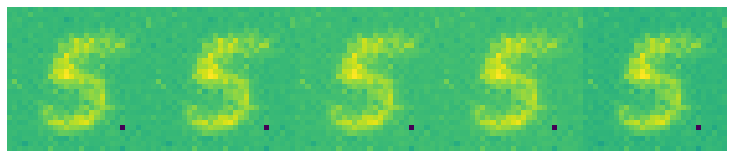

Epoch: 11/100 Loss: -4724.7833


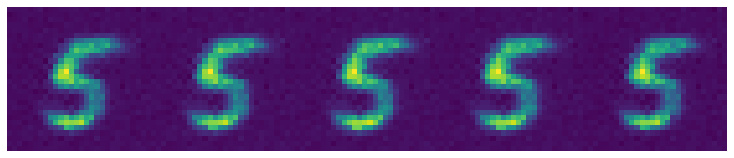

Epoch: 21/100 Loss: -4815.6837


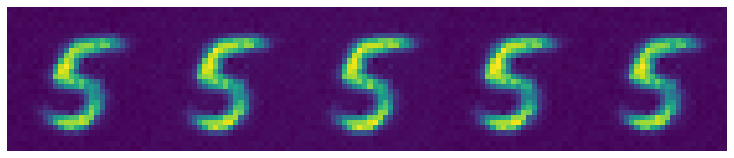

Epoch: 31/100 Loss: -4857.8791


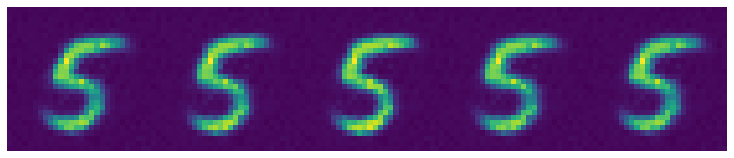

Epoch: 41/100 Loss: -4889.1844


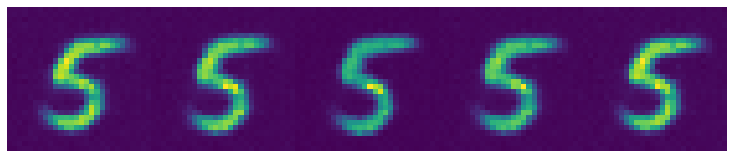

Epoch: 51/100 Loss: -4908.5130


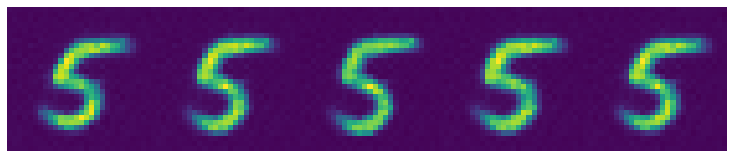

Epoch: 61/100 Loss: -4926.4019


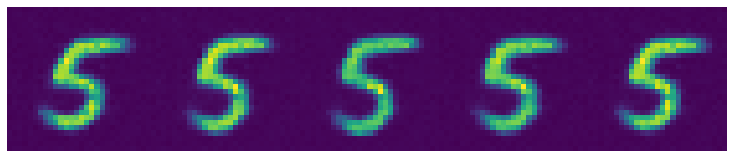

Epoch: 71/100 Loss: -4938.5495


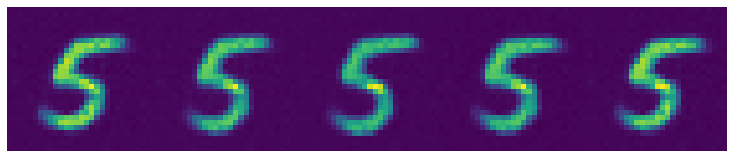

Epoch: 81/100 Loss: -4950.4116


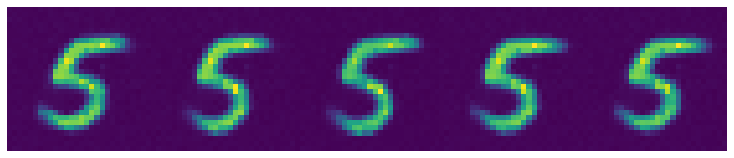

Epoch: 91/100 Loss: -4959.6571


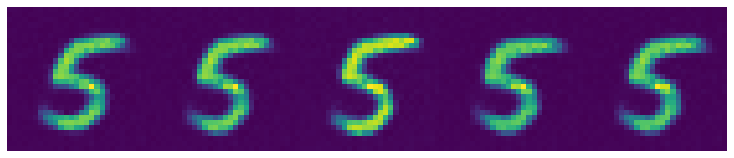

In [11]:
sample_noise = torch.randn(5,28,28).to(device)

for i in range(n_epochs):
    model.train()
    loss_acc = 0
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x = (x.float() + torch.randn(x.shape) / 64.).to(device)
        z, logdetJ = model.forward_flow(x)
        loss = nf_loss(z, logdetJ)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print(f'Epoch: {i + 1}/{n_epochs} Loss: {(loss_acc / (j+1)):.4f}')
        with torch.no_grad():
            model.eval()
            samples = model.inverse_flow(sample_noise)
            plot(samples)

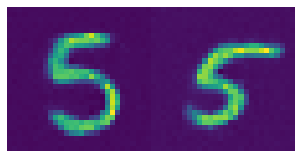

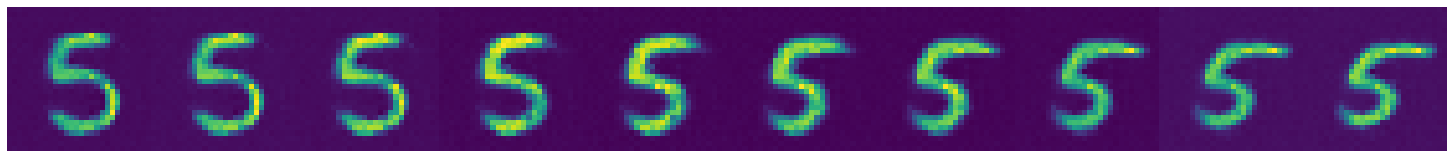

In [12]:
seed = 42
n = 1000

torch.manual_seed(seed)
zs = torch.randn(n, 28, 28)
with torch.no_grad():
    model.eval()

    xs = model.inverse_flow(zs)
    xs_flat = xs.reshape(n, -1)

    dsts = torch.cdist(xs_flat, xs_flat)
    max_pair = (dsts==torch.max(dsts)).nonzero()[0]
    im0 = xs[max_pair[0]]
    im1 = xs[max_pair[1]]
    z0 = zs[max_pair[0]]
    z1 = zs[max_pair[1]]

    plot([im0, im1])

    lin_space = torch.linspace(0, 1, 10).unsqueeze(1).unsqueeze(2)
   
    z0 = z0.unsqueeze(0).expand(10, -1, -1)
    z1 = z1.unsqueeze(0).expand(10, -1, -1)

    zs = torch.mul(lin_space, z1) + (1 - lin_space) * z0
    ims = model.inverse_flow(zs)

    plot(ims)

torch.Size([1, 28, 28])


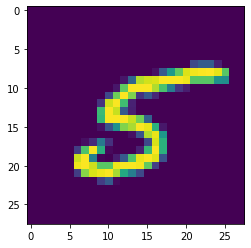

In [243]:
id = 42

image = x[id].unsqueeze(0)

print(image.shape)
xh = torch.rand(1, 28, 14, dtype=torch.float) - 0.5

xh.requires_grad = True

optimizer = torch.optim.Adam([xh], lr=0.15) 
plt.imshow(image[0])

I 0: LOSS; 1826440.625


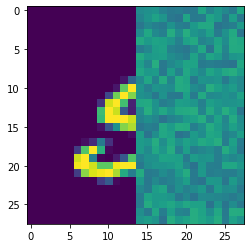

I 500: LOSS; 69149.7109375
I 1000: LOSS; 22358.89453125
I 1500: LOSS; 10259.359375
I 2000: LOSS; 4941.9638671875
I 2500: LOSS; 2209.98779296875


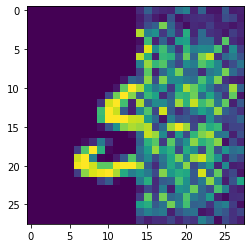

I 3000: LOSS; 326.1745910644531
I 3500: LOSS; -733.0457763671875
I 4000: LOSS; -1568.1397705078125
I 4500: LOSS; -2191.88818359375
I 5000: LOSS; -2692.5908203125


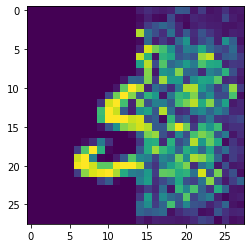

I 5500: LOSS; -3047.83544921875
I 6000: LOSS; -3324.700927734375
I 6500: LOSS; -3556.8232421875
I 7000: LOSS; -3712.693359375
I 7500: LOSS; -3836.965576171875


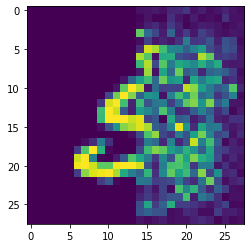

I 8000: LOSS; -3940.6533203125
I 8500: LOSS; -4040.600830078125
I 9000: LOSS; -4155.025390625
I 9500: LOSS; -4286.1357421875
I 10000: LOSS; -4417.7587890625


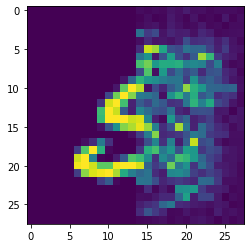

I 10500: LOSS; -4539.5888671875
I 11000: LOSS; -4669.35009765625
I 11500: LOSS; -4804.92138671875
I 12000: LOSS; -4960.43701171875
I 12500: LOSS; -5142.2646484375


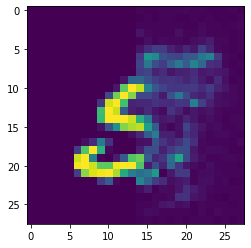

I 13000: LOSS; -5311.60888671875
I 13500: LOSS; -5410.95703125
I 14000: LOSS; -5466.80908203125
I 14500: LOSS; -5506.30859375
I 15000: LOSS; -5521.72216796875


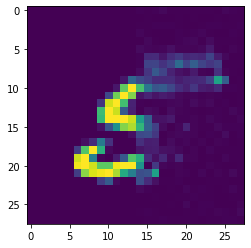

I 15500: LOSS; -5529.9453125
I 16000: LOSS; -5535.1015625
I 16500: LOSS; -5539.83154296875
I 17000: LOSS; -5548.34375
I 17500: LOSS; -5560.87744140625


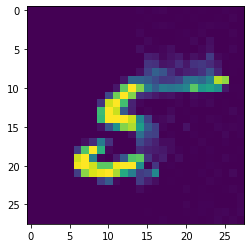

I 18000: LOSS; -5566.08056640625
I 18500: LOSS; -5570.07275390625
I 19000: LOSS; -5572.8505859375
I 19500: LOSS; -5574.70263671875
I 20000: LOSS; -5579.740234375


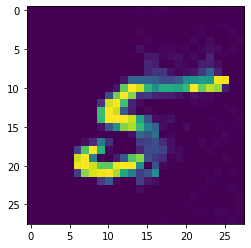

I 20500: LOSS; -5581.7373046875
I 21000: LOSS; -5585.32666015625
I 21500: LOSS; -5586.17529296875
I 22000: LOSS; -5591.1787109375
I 22500: LOSS; -5593.59814453125


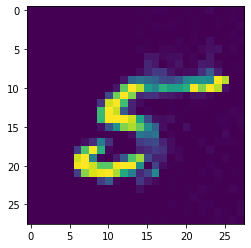

I 23000: LOSS; -5590.04443359375
I 23500: LOSS; -5595.64013671875
I 24000: LOSS; -5600.33154296875
I 24500: LOSS; -5543.32666015625
_____


In [244]:
ITERS = 25000
imgs = []
model.eval()
for i in range(ITERS):
    optimizer.zero_grad()
    inpainted_x = image.clone()
    inpainted_x[:,:,14:] = torch.sigmoid(xh) - 0.5
    z, logdetJ = model.forward_flow(inpainted_x)
    logpx = nf_loss(z, logdetJ)
    if i % (ITERS//50) == 0:
        print(f"I {i}: LOSS; {logpx.item()}")
    logpx.backward()
    optimizer.step()  
    if i % (ITERS//10) == 0:
        imgs.append(inpainted_x[0].detach())
        plt.imshow(inpainted_x[0].detach())
        plt.show()
        
    

print("_____")
inpainted_x = image.clone()
inpainted_x[:,:,14:] = torch.sigmoid(xh) - 0.5
imgs.append(inpainted_x[0].detach())

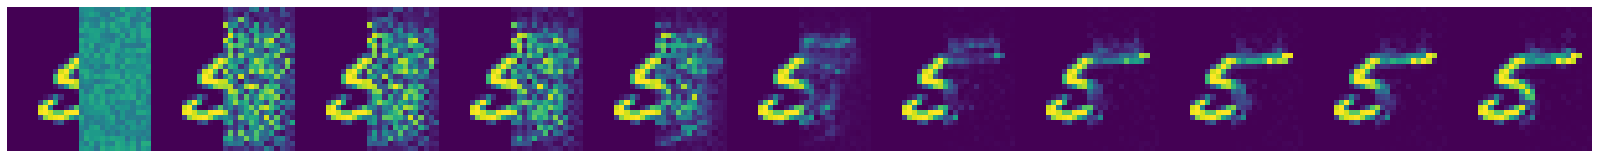

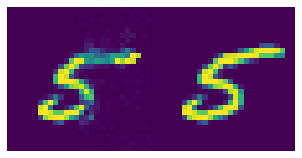

In [248]:
plot(imgs)
plot([imgs[-1], image[0]])

In [249]:
torch.save(model.state_dict(), 'nf_model.params')

# Report

## Model

### Architecture

I am using simple NN with 2 linear layer (hid dim = 256) with sigmoid activation for scaling and transition networks in my coupling layers. I use 10 coupling layers.

### Masks

I chose to use simple checkboard masks. I tried with many different kinds of masks but all-checkboard setup worked the best

### Training

I trained model in 100 epochs with Adam optimizer with default hiperparameters

## Interpolation

You can see that interpolation in a latent space gives a quite continuous results in a data space. This proves that the latent space entanglement is quite low, which is good. 

## Inpainting reconstruction

My model needs ~20000 iterations to reconstruct an image. As you can see it gives pretty good results, although there is a space for improvement. I optimise the inprinted part with Adam and not using the method showed in a paper as it is more efficioent.